## Learn to Play video Game 

Remember: put everything on GPU!!

In [0]:
# Install Pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
# Needed to get the gym environment working
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip3 install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig3.0 is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
ln: failed to create symbolic link '/usr/bin/swig': File exists


In [3]:
!pip install gym

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
import numpy as np
import gym
import copy

from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn')

from collections import deque

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

np.random.seed(1)

In [6]:
ENV = gym.make('LunarLander-v2')
NS = ENV.observation_space.shape[0]  
NA = 1
DEFAULT_PARAMS = {'bn':10, 'bs':256, 'gamma':0.9, 'ns':NS, 'na':NA}
LR = 1e-4

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [7]:
print(ENV.observation_space, ENV.action_space)

Box(8,) Discrete(4)


In [8]:
ENV.reset()

array([-0.00472307,  1.415428  , -0.4784209 ,  0.20033912,  0.00547975,
        0.10836941,  0.        ,  0.        ], dtype=float32)

In [0]:
class RandomAgent():
    
    def __init__(self, env, clip_reward = False):
        self.env = env
        self.max_rounds = int(1e4)
        self.clip_reward = clip_reward
        self.n = 0  # Number of exploration rounds
        
    def randomAction(self):
        return self.env.action_space.sample()
    
    def pi(self, state, explore):
        return self.randomAction()
    
    def playPol(self, save_frames = False, explore = False):
        '''Plays a game from start to finish. '''
        
        if explore: self.n += 1
            
        state = self.env.reset()
        frames = []; reward = 0
        self.history = deque()
        for i in range(self.max_rounds):       
            if save_frames: frames.append(self.env.render(mode = 'rgb_array'))
            action = self.pi(state, explore)
            newstate, r, done, _ = self.env.step(action)
            self.history.append((state, action, r, done, newstate))
            if self.clip_reward:
                r = max(min(r, 1), -1)
            reward += r
            if done: break
        if save_frames: self.env.close()
        return (reward, frames)

In [0]:
random_guy = RandomAgent(ENV)

In [11]:
random_guy.playPol()

(-216.1838227117045, [])

In [12]:
random_guy.history[3]

(array([ 0.005655  ,  1.4103663 ,  0.5727736 , -0.0246282 , -0.00654593,
        -0.12974174,  0.        ,  0.        ], dtype=float32),
 0,
 -0.9294738261610576,
 False,
 array([ 0.02838745,  1.4022259 ,  0.57387084, -0.13061185, -0.03495537,
        -0.13539419,  0.        ,  0.        ], dtype=float32))

## Create Neural Net Architecture

The task is pretty simple: take the inputs (8), and return the Q function (the value of each action). That is a NN with 8 inputs, 4 outputs, as many hidden layers as we want

In [0]:
arch = nn.Sequential(nn.BatchNorm1d(8, affine = False),
                    nn.Linear(8, 50), 
                    nn.LeakyReLU(inplace = True), 
                    nn.BatchNorm1d(50), 
                    nn.Linear(50, 4))           

In [14]:
state = torch.tensor(ENV.reset()[None])
arch.eval()
with torch.no_grad():
    print(arch(state).numpy()[0])

[ 0.05454669  0.06599295 -0.04727311 -0.01109632]


## Create Deep Q Agent

In [0]:
class DQAgent(RandomAgent):
    
    def __init__(self, env, arch):
        super().__init__(env)
        self.arch = arch
    
    def getQ(self, state):
        self.arch.eval()
        with torch.no_grad():
            inp = torch.tensor(state[None])
            return self.arch(inp).numpy()[0]
        
    def getOptimalAction(self, state):
        return np.argmax(self.getQ(state))
    
    def get_exp_frac(self, low_lim = 0.05, high_lim = 0.9999, n_taper = 1e-4):
        n = self.n
        #frac = low_lim + high_lim  / (1 + n * n_taper)
        frac = high_lim - (high_lim - low_lim) * n * n_taper
        self.exp_frac = max(min(frac, high_lim), low_lim)
        
    def playPol(self, save_frames = False, explore = False):
        
        self.get_exp_frac()
        return super().playPol(save_frames, explore)
    
    def do_exploration(self):
        return np.random.rand() < self.exp_frac        
    
    def pi(self, state, explore = False):
        if explore and self.do_exploration():
            return self.randomAction()
        else:
            return self.getOptimalAction(state)

In [16]:
dqn_guy = DQAgent(ENV, arch)
dqn_guy.playPol()

(-170.79260856829626, [])

## Create a buffer of experience replay

In [0]:
class Buffer_Filler():
    def __init__(self, agent, buffer_size = 200, params = DEFAULT_PARAMS):
        self.buffer_size = buffer_size
        self.agent = agent
        self.ns = params['ns']
        self.na = params['na']
        
    def init_empty(self):
        states = np.zeros((self.buffer_size, self.ns))
        actions = np.zeros((self.buffer_size, self.na))
        dones = np.zeros((self.buffer_size, 1))
        rewards = np.zeros((self.buffer_size, 1))
        next_states = states.copy()
        self.buffer = (states, actions, dones, rewards, next_states)
    
    def fill_buffer(self):
        self.init_empty()
        (states, actions, rewards, dones, next_states) = self.buffer
        
        i = 0
        while i < self.buffer_size:
            self.agent.playPol(explore = True)
            n = len(self.agent.history)
            for j in range(n):
                s, a, r, d, nst = self.agent.history.popleft()
                idx = i + j
                if idx >= self.buffer_size:
                    break
                states[idx, :] = s; actions[idx, :] = a; dones[idx, :] = d 
                rewards[idx, :] = r; next_states[idx, :] = nst
            i += n
        self.buffer = (states, actions, rewards, dones, next_states)

In [0]:
bf = Buffer_Filler(dqn_guy)

In [0]:
bf.fill_buffer()

In [20]:
bf.buffer[0][13], bf.buffer[1][13], bf.buffer[2][13], bf.buffer[3][13], bf.buffer[4][13], 

(array([-0.00220852,  1.3982991 , -0.22371809, -0.56094223,  0.00256595,
         0.05067556,  0.        ,  0.        ]),
 array([3.]),
 array([-1.0254488]),
 array([0.]),
 array([-0.03361387,  1.18950188, -0.22794297, -0.786632  ,  0.04646631,
         0.08570468,  0.        ,  0.        ]))

## Create a mini-batch of experience

In [0]:
class replay_Dataset(Dataset):
    
    def __init__(self, states, actions, y):
        super().__init__()
        
        self.size = states.shape[0]        
        assert self.size == actions.shape[0]
        assert self.size == y.shape[0]
        
        self.states = states
        self.actions = actions
        self.y = y
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.y[idx]

In [0]:
class Minibatcher(Buffer_Filler):
    
    ## Later: 10 batches of 128
    
    def __init__(self, agent, params = DEFAULT_PARAMS):
        
        self.bn = params['bn']
        self.bs = params['bs']
        super().__init__(agent, self.bn*self.bs, params)
        
        self.gamma = params['gamma']
        self.eval_arch = copy.deepcopy(self.agent.arch)
        self.eval_arch.eval()
        
        
    def getX(self):
        return (torch.tensor(self.buffer[0], dtype = torch.float32),
                torch.tensor(self.buffer[1], dtype = torch.int64))
        
    def getY(self):
        
        __, __, rewards, dones, next_states = self.buffer
        next_states = torch.tensor(next_states, dtype = torch.float32)
        
        
        with torch.no_grad():
            next_values = self.eval_arch(next_states).max(1)[0]
            
        done_mask = torch.ByteTensor(dones)
        next_values[done_mask.squeeze()] = 0.0
        
        rewards = torch.tensor(rewards, dtype = torch.float32).squeeze()
        
        expected_values = next_values.squeeze() * self.gamma + rewards
        
        return expected_values
        
    def createDS(self):
        self.fill_buffer()
        states, actions = self.getX()
        y = self.getY()
        self.ds = replay_Dataset(states, actions, y)
        
    def createDL(self):
        self.createDS()
        self.dl = DataLoader(self.ds, batch_size = self.bs, shuffle=True,
                            num_workers = 4)    

In [0]:
mb = Minibatcher(dqn_guy)

In [0]:
mb.createDL()

In [25]:
len(mb.ds)

2560

In [26]:
mb.ds.__getitem__(3)

(tensor([ 0.0026,  1.4133,  0.2670,  0.1057, -0.0030, -0.0605,  0.0000,  0.0000]),
 tensor([3]),
 tensor(-1.1984))

## Calculate Loss

In [0]:
def loss_batch(states, actions, ys, model, opt=None):
    
    '''Calculates the loss for a minibatch, and (if opt is given) updates parameters'''
    
    loss_func = nn.MSELoss()
    
    expected = torch.gather(model(states), 1, actions).cuda()  
    loss = loss_func(expected.squeeze(), ys.cuda())
    
    if opt is not None:  # Update parameters
        opt.zero_grad(); loss.backward(); opt.step()
        
    return loss.item(), len(ys)

In [0]:
states, actions, ys = next(iter(mb.dl))

In [29]:
loss_batch(states, actions, ys, arch)

(49.6864128112793, 256)

## Create a trainer

In [0]:
def run_avg(x, beta = 0.95, bias_correct = True):
    '''Calculates exponential running average of x.'''
    r = 0; res = np.zeros(len(x))
    for i in range(len(x)):
        r = beta*r + (1-beta)*x[i]
        res[i] = r
    if bias_correct:
        res = res / (1 - beta **(np.arange(len(x))+1))
    return res

In [0]:
class Learner(Minibatcher):
    
    '''This class trains our policy.'''
    
    def __init__(self, agent, params = DEFAULT_PARAMS):       
        
        super().__init__(agent, params = params)
        self.epoch = 0  # The number of epochs for training.
        self.rewards = []  # List of rewards      
        self.losses = []
        
    def train(self, epochs, lr): 
        '''Trains our policy for epochs rounds with learning rate lr.'''
        for epoch in tqdm(range(epochs), position = 0):
            if (epoch) % 10 == 0:  # Update plot every 10 rounds
                self.plot_reward()
                display.clear_output(wait=True)
                display.display(plt.gcf())
            self.train_episode(lr)
        plt.close('all')
    
    def train_episode(self, lr):
        '''Trains our policy for a single epoch.'''
        
        self.epoch += 1      
        self.createDL()   # Creates minibatch of replays to train on
        
        model = self.agent.arch
        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.95,
                        weight_decay=1e-3)
        
        # Train Neural Net
        model.train()
        for sb, ab, yb in self.dl:
            self.losses.append(loss_batch(sb, ab, yb, model, opt)[0])       
        model.eval()
        
        # Play once; calculate and return  reward
        rew, _ = self.agent.playPol(explore = True)
        self.rewards.append(rew)
        return rew
        
    def plot_reward(self):
        '''Plot rewards.'''
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                                    sharex = False, sharey = False)
        ax2.set_yscale('log')
        ax2.set_yscale('linear')
        ax1.plot(run_avg(self.rewards, beta = 0.99), '-')
        ax2.plot(run_avg(self.losses, beta = 0.999), '-')

In [0]:
arch = nn.Sequential(nn.BatchNorm1d(8, affine = False),
                    nn.Linear(8, 50), 
                    nn.LeakyReLU(inplace = True), 
                    nn.BatchNorm1d(50), 
                    nn.Linear(50, 4))     

dqn_guy = DQAgent(ENV, arch)
learn = Learner(dqn_guy)

In [33]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-578.1091766405951

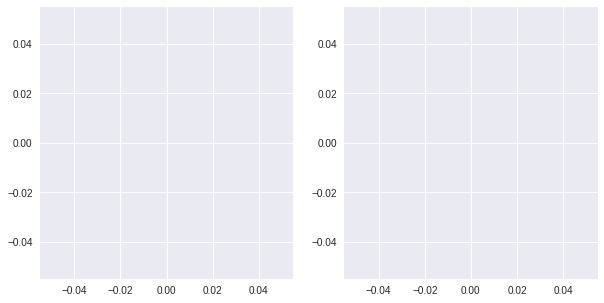

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


In [34]:
learn.train(1, LR)

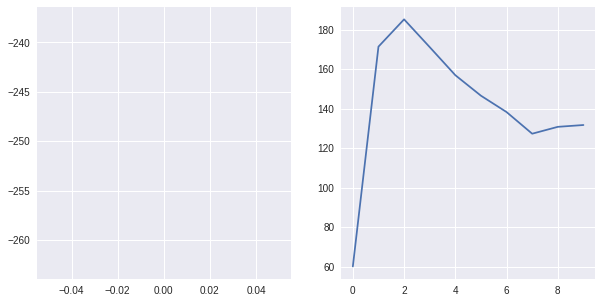

100%|██████████| 10/10 [00:09<00:00,  1.12it/s]


In [35]:
learn.train(10, LR)

In [36]:
learn.agent.exp_frac

0.96997815

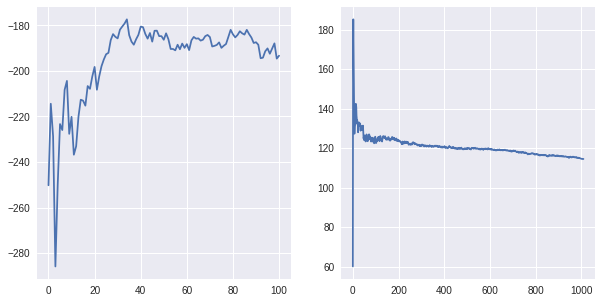

100%|██████████| 100/100 [01:48<00:00,  1.25s/it]


In [37]:
learn.train(100, LR)

In [38]:
learn.agent.exp_frac

0.71179533

In [39]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-588.50144479292

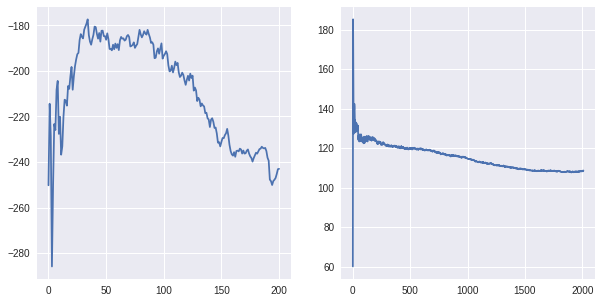

100%|██████████| 100/100 [02:22<00:00,  1.44s/it]


In [40]:
learn.train(100, LR)

In [41]:
learn.agent.exp_frac

0.46995079000000006

In [42]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-253.40831969730579

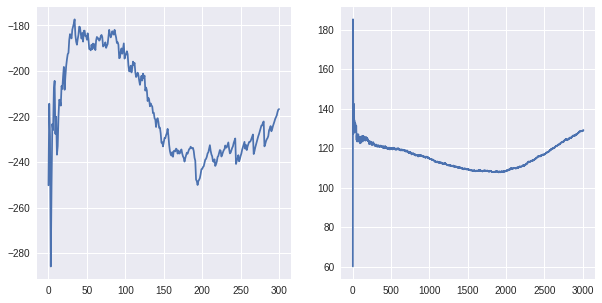

100%|██████████| 100/100 [02:19<00:00,  1.29s/it]


In [43]:
learn.train(100, LR)

In [44]:
learn.agent.exp_frac

0.1532541300000001

In [45]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-171.14961711667237

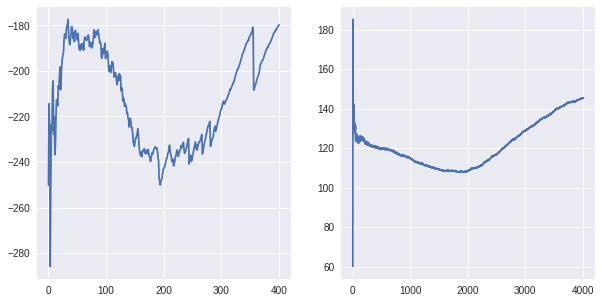

100%|██████████| 100/100 [02:15<00:00,  1.19s/it]


In [46]:
learn.train(100, LR)

In [47]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-123.48713711836761

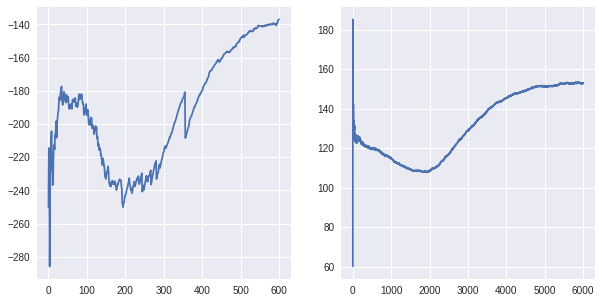

100%|██████████| 200/200 [04:21<00:00,  1.25s/it]


In [48]:
learn.train(200, LR)

In [49]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

-196.9048304677073

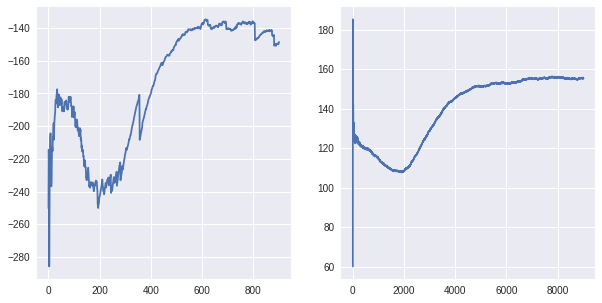

100%|██████████| 300/300 [06:52<00:00,  1.26s/it]


In [50]:
learn.train(300, LR)

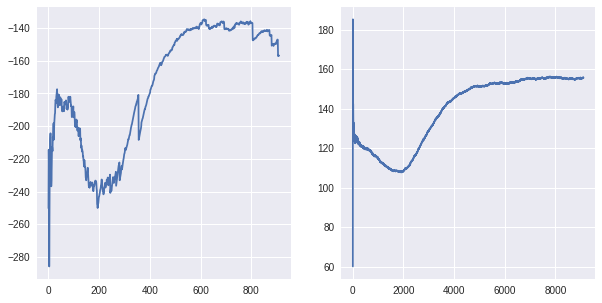

  2%|▏         | 7/300 [00:09<06:32,  1.34s/it]


KeyboardInterrupt: ignored

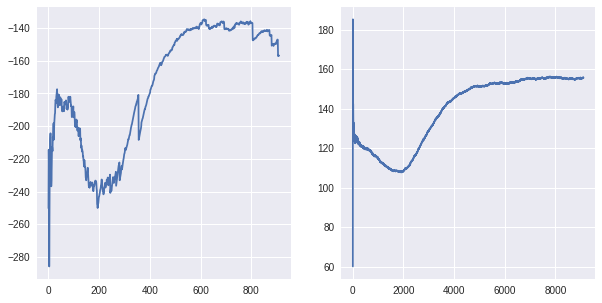

In [51]:
learn.train(300, LR)

In [0]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])

In [0]:
learn.train(500, LR)

In [0]:
learn.train(500, LR/100)

In [0]:
np.mean([dqn_guy.playPol()[0] for i in range(100)])